# (0.1) Train multiple-imputation (MI) models
One option to resolve missingness for AFA is to use Multiple Imputation. 
This notebook trains MI models and saves the multiple imputed datasets. 

In [1]:
%load_ext autoreload
%autoreload 2

## Define paths

In [2]:
from afa.configurations.utils_ts import specify_default_paths_ts
# which dataset to work on 
dataset_name   = "synthetic_1"

# name for of missingness scenario 
miss_scenario  = 'MCAR_1'

# automatically specify some path locations (change paths manually if needed) 
paths = specify_default_paths_ts(dataset_name = dataset_name , miss_scenario = miss_scenario) 

# name for ps_model 
mi_model_name  = 'mi_simple'
mi_model_name  = 'mi_simple_gp'

# new (where to save the model) 
mi_model_dir = paths['data_dir']  + 'mi_models' + '/' + mi_model_name + '/'


### Define model specifications

In [46]:
device = 'cpu'  # 'cuda' or 'cpu'

dataset_params = {
    'missingness_value': 'nan',   # int, float or 'nan'
    'missingness_rate': (0.1, 0.3),
    'device': device  # 'cuda' or 'cpu'
}

dataloader_params = {
    'batch_size': 100, 
    'shuffle': False, 
    # 'prefetch_factor': 1, # increase for speed up
    # 'num_workers': 0,     # set higher for faster throughput
    'drop_last': True
}

trainer_params = {
    'max_epochs': 100,    # number of epochs to train
    'auto_lr_find': False,
    'fast_dev_run': False,
    'accelerator': device,
    'devices': 1,
    'profiler': None  # 'simple', 'advanced', None
}

mi_model_params = {
    'name' : mi_model_name, 
    'directory' : mi_model_dir,
    'base_model_params' : {
        'model_type': 'gaussian_process',
        'dataset_params' : dataset_params,
        'dataloader_params' : dataloader_params,
        'trainer_params' : trainer_params,
        'num_tasks': 5,  # number of tasks == number of features
        'num_kernels': 10
    }
}
mi_model_params['base_model_params']['dataloader_params'].keys()

dict_keys(['batch_size', 'shuffle', 'drop_last'])

## Load dataset with missingness 
At first, we want to load the dataset 

Includes loading: 
- superfeature mapping
- problem
- afa_problem 
- missingness_model

In [3]:
from afa.data_modelling.datasets.data_loader.data_loader_ts import DataLoader_ts

2023-03-20 19:38:36.956868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 19:38:37.041599: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-20 19:38:37.041615: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-20 19:38:40.031310: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [5]:
data_loader = DataLoader_ts(data_file                  = paths['data_file'],
                            temporal_data_file         = paths['temporal_data_file'],
                            superfeature_mapping_file  = paths['superfeature_mapping_file'],
                            problem_file               = paths['problem_file'],
                            afa_problem_files          = paths['afa_problem_files'], 
                            miss_model_files           = paths['miss_model_files'], 
                            folds_file                 = paths['folds_file'] )
dataset = data_loader.load()

100%|██████████| 100/100 [00:00<00:00, 1776.17it/s]


In [6]:
type(dataset.get_data(fold=None, split='train')['temporal_feature'])
dataset.get_data(fold=None, split='train')['temporal_feature'].shape

(100, 5, 4)

## Define MI model

In [47]:
from afa.data_modelling.missingness.multiple_imputation.multiple_imputation_model_ts import MultipleImputationModel_ts

mi_model = MultipleImputationModel_ts(  
                name                         = mi_model_params['name'], 
                m_graph                      = dataset.miss_model.m_graph, 
                superfeature_mapping         = dataset.superfeature_mapping,
                target_superfeature_names    = dataset.afa_problem.target_superfeature_names,
                model_params                 = mi_model_params,
                directory                    = mi_model_params['directory'] ) 

Global seed set to 42


{'dataset_name': 'toydataset_50000', 'data_missingness': 0.6, 'num_kernels': 10, 'num_tasks': 5, 'rank': 4, 'data_mode': 'simulation', 'lr': 0.01, 'batch_size': 128, 'sample_tp': 0.4, 'sample_tp_interval': [0.3, 0.8], 'num_epochs': 10, 'model_weights_save_path': './model_weights', 'model_type': 'gaussian_process', 'dataset_params': {'missingness_value': 'nan', 'missingness_rate': (0.1, 0.3), 'device': 'cpu'}, 'dataloader_params': {'batch_size': 100, 'shuffle': False, 'drop_last': True}, 'trainer_params': {'max_epochs': 100, 'auto_lr_find': False, 'fast_dev_run': False, 'accelerator': 'cpu', 'devices': 1, 'profiler': None}, 'directory': '../../../data/ts/synthetic_1/MCAR_1/mi_models/mi_simple_gp/', 'mode': 'imputation', 'task_names': ['Noise', 'Trend', 'Seasonality', 'Trend + Seasonality']} 




GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Train MI model 

In [77]:
mi_model.base_model.trainer.fit_loop.max_epochs = 300
mi_model.base_model.device

'cpu'

In [82]:
mi_model.fit(dataset, fold = None, train_split = 'train', valid_split = 'val', fit_again = False)


  | Name     | Type                       | Params
--------------------------------------------------------
0 | mae_loss | L1Loss                     | 0     
1 | mgp      | HadamardGP                 | 270   
2 | mll      | ExactMarginalLogLikelihood | 270   
--------------------------------------------------------
270       Trainable params
0         Non-trainable params
270       Total params
0.001     Total estimated model params size (MB)


Epoch 234:   0%|          | 0/2 [00:00<?, ?it/s, loss=1.5, v_num=19]         

ZeroDivisionError: integer division or modulo by zero

['pred_mean_batch: torch.Size([10, 5, 5])', 'quantile_low_batch: torch.Size([10, 5, 5])', 'quantile_high_batch: torch.Size([10, 5, 5])', 'sampled_seqs_batch: torch.Size([10, 100, 5, 5])']


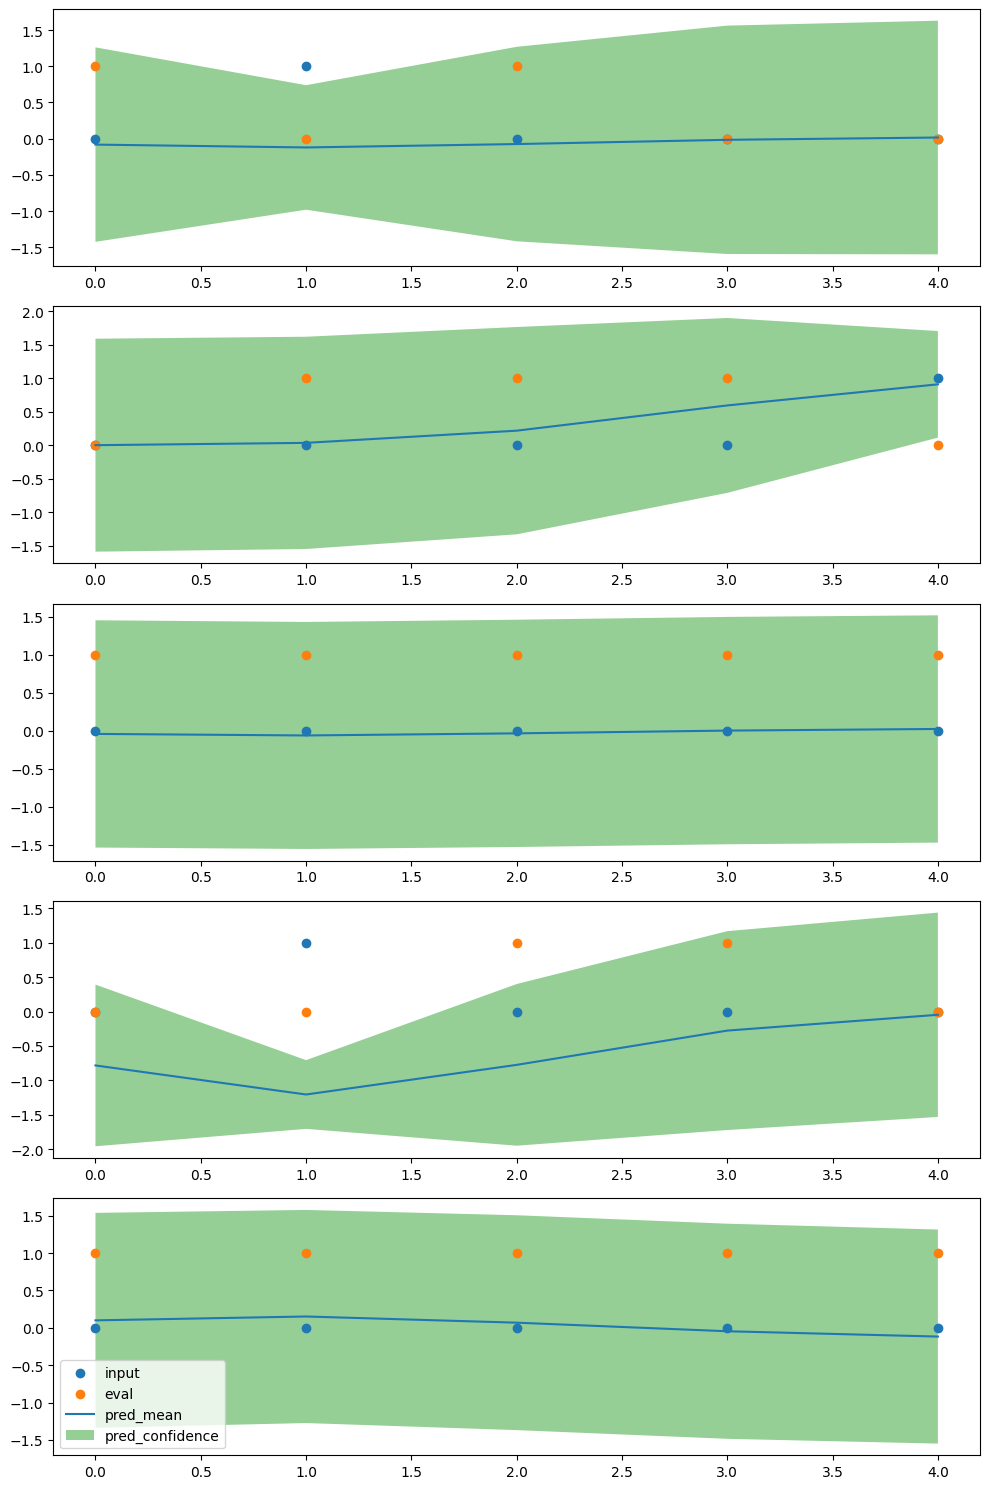

In [81]:
import afa.data_modelling.models.temporal_models.mi_models.gp_model as GPFile
from afa.data_modelling.models.temporal_models.mi_models.gp_model import MGPImputer
from afa.data_modelling.models.temporal_models.mi_models.missingness_dataloader import MissingnessDataset
from torch.utils.data import DataLoader
import numpy as np

data = dataset.get_data(fold = None, split = 'train')
Xy_train, t_train = mi_model._preprocess(data)
Xyt_train = np.concatenate([Xy_train, t_train], axis=-1)
index = slice(10)
Xy = Xy_train[index]
t = t_train[index]
Xyt = Xyt_train[index]

GaussianProcessImputer = mi_model.base_model
gp_model = GaussianProcessImputer.gpmodel
assert(isinstance(gp_model, MGPImputer))

# prepare data in batches
dataloader = DataLoader(MissingnessDataset(Xyt, missingness_value='nan', missingness_rate=0.1), batch_size=10, shuffle=False)
batch = next(iter(dataloader))
masks, values, t = GPFile.mask_collate(batch)

# impute a batch
pred_mean_batch, quantile_low_batch, quantile_high_batch, sampled_seqs_batch, mask_dict_batch = gp_model.impute_and_sample_in_batch(masks, values, t, sample_size=100)
outcomes = [pred_mean_batch, quantile_low_batch, quantile_high_batch, sampled_seqs_batch]
names = ['pred_mean_batch', 'quantile_low_batch', 'quantile_high_batch', 'sampled_seqs_batch']
print([name + ': ' + str(outcome.shape) for name, outcome in zip(names, outcomes)])

# plot a sample from a batch
sample_index = 1
X_miss = masks[sample_index]
t_context = t
t_target = t
pred_mean = pred_mean_batch[sample_index]
quantile_low = quantile_low_batch[sample_index]
quantile_high = quantile_high_batch[sample_index]
mask_dict = {key:mask[sample_index] for key, mask in mask_dict_batch.items()}
observed_pred = None
gp_model.plot_sample(X_miss, t_context, t_target, pred_mean, quantile_low, quantile_high, mask_dict, observed_pred=None)

In [ ]:
GaussianProcessImputer.get_checkpoint('best_model-v_recon_loss_target=1.76-epoch=3.ckpt')

FileNotFoundError: The requested model version sdgfr does not exist. The following versions are available: (please copy one below and enter it as version argument)
	- best_model-v_recon_loss_target=1.76-epoch=3.ckpt
	- best_model-v_recon_loss_target=2.63-epoch=1.ckpt
	- best_model-v_recon_loss_target=2.55-epoch=2.ckpt
	- best_model-v_recon_loss_target=2.63-epoch=1-v1.ckpt
	- best_model-v_recon_loss_target=2.55-epoch=2-v1.ckpt
	- best_model-v_recon_loss_target=2.63-epoch=1-v2.ckpt
	- best_model-v_recon_loss_target=2.55-epoch=2-v2.ckpt
	- best_model-v_recon_loss_target=2.63-epoch=1-v3.ckpt
	- best_model-v_recon_loss_target=2.55-epoch=2-v3.ckpt
	- best_model-v_recon_loss_target=2.63-epoch=1-v4.ckpt
	- best_model-v_recon_loss_target=2.55-epoch=2-v4.ckpt
	- best_model-v_recon_loss_target=2.63-epoch=1-v5.ckpt
	- best_model-v_recon_loss_target=2.55-epoch=2-v5.ckpt
	- best_model-v_recon_loss_target=2.63-epoch=1-v6.ckpt
	- best_model-v_recon_loss_target=2.55-epoch=2-v6.ckpt
	- best_model-v_recon_loss_target=2.63-epoch=1-v7.ckpt
	- best_model-v_recon_loss_target=2.55-epoch=2-v7.ckpt
	- best_model-v_recon_loss_target=2.63-epoch=1-v8.ckpt
	- best_model-v_recon_loss_target=2.55-epoch=2-v8.ckpt
	- best_model-v_recon_loss_target=1.44-epoch=27.ckpt
	- best_model-v_recon_loss_target=2.01-epoch=99.ckpt
	- best_model-v_recon_loss_target=1.42-epoch=29.ckpt
	- best_model-v_recon_loss_target=2.56-epoch=28.ckpt
	- best_model-v_recon_loss_target=2.03-epoch=98.ckpt
	- best_model-v_recon_loss_target=2.55-epoch=29.ckpt
	- best_model-v_recon_loss_target=1.98-epoch=2.ckpt
	- best_model-v_recon_loss_target=2.77-epoch=1.ckpt
	- best_model-v_recon_loss_target=2.77-epoch=2.ckpt
	- best_model-v_recon_loss_target=2.73-epoch=1.ckpt
	- best_model-v_recon_loss_target=2.55-epoch=29-v1.ckpt
	- best_model-v_recon_loss_target=2.56-epoch=28-v2.ckpt
	- best_model-v_recon_loss_target=2.56-epoch=28-v1.ckpt
	- best_model-v_recon_loss_target=2.70-epoch=2.ckpt
	- best_model-v_recon_loss_target=2.73-epoch=1-v1.ckpt
	- best_model-v_recon_loss_target=2.70-epoch=2-v1.ckpt
	- best_model-v_recon_loss_target=2.65-epoch=17.ckpt
	- best_model-v_recon_loss_target=2.64-epoch=18.ckpt
	- best_model-v_recon_loss_target=2.55-epoch=29-v2.ckpt
	- best_model-v_recon_loss_target=2.56-epoch=28-v3.ckpt
	- best_model-v_recon_loss_target=2.55-epoch=29-v3.ckpt
	- best_model-v_recon_loss_target=1.55-epoch=201.ckpt
	- best_model-v_recon_loss_target=1.56-epoch=197.ckpt

In [44]:
GaussianProcessImputer.pars

{'dataset_name': 'toydataset_50000',
 'data_missingness': 0.6,
 'num_kernels': 10,
 'num_tasks': 5,
 'rank': 4,
 'data_mode': 'simulation',
 'lr': 0.01,
 'batch_size': 128,
 'sample_tp': 0.4,
 'sample_tp_interval': [0.3, 0.8],
 'num_epochs': 10,
 'model_weights_save_path': './model_weights',
 'model_type': 'gaussian_process',
 'dataset_params': {'missingness_value': 'nan',
  'missingness_rate': 0.0,
  'device': 'cpu'},
 'dataloader_params': {'batch_size': 100, 'shuffle': False, 'drop_last': True},
 'trainer_params': {'max_epochs': 30,
  'auto_lr_find': False,
  'fast_dev_run': False,
  'accelerator': 'cpu',
  'devices': 1,
  'profiler': None},
 'directory': '../../../data/ts/synthetic_1/MCAR_1/mi_models/mi_simple_gp/',
 'mode': 'imputation',
 'task_names': ['Noise', 'Trend', 'Seasonality', 'Trend + Seasonality']}

## Create multiple imputed dataset

In [1]:
from afa.data_modelling.missingness.multiple_imputation.multiple_imputed_dataset_ts import MultipleImputedDataset_ts

In [2]:
mi_results = mi_model.predict(dataset, n_samples = 5)

# create an mi_dataset out of the generated imputations
mi_dataset = MultipleImputedDataset_ts(  dataset = dataset, model = mi_model, results = mi_results) 

NameError: name 'mi_model' is not defined

## Evaluate imputation model on ground truth dataset

In [ ]:
# TO DO

## Save MI dataset

In [ ]:
mi_dataset.save( model_dir = mi_model_dir) 